In [57]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [58]:
torch.__version__

'1.13.1+cu116'

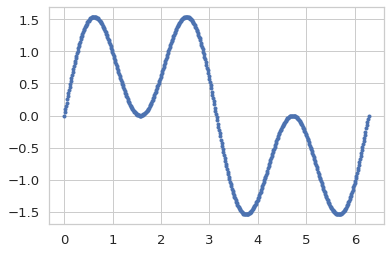

In [59]:
X = torch.linspace(0,2*np.pi,500)
Y = torch.sin(X) + torch.sin(3*X)
plt.plot(X,Y,'.')

In [60]:
class FC_model(torch.nn.Module):
    def __init__(self,n_hidden=10):
        super().__init__()
        self.lin_layer_1 = torch.nn.Linear(1,10)
        self.lin_layer_2 = torch.nn.Linear(10,20)
        self.lin_layer_3 = torch.nn.Linear(20,100)
        self.lin_layer_4 = torch.nn.Linear(100,50)
        self.lin_layer_5 = torch.nn.Linear(50,10)
        self.lin_layer_6 = torch.nn.Linear(10,1)


        
    def forward(self,x):
        x = F.relu(self.lin_layer_1(x))
        x = F.relu(self.lin_layer_2(x))
        x = F.relu(self.lin_layer_3(x))
        x = F.relu(self.lin_layer_4(x))
        x = F.relu(self.lin_layer_5(x))
        y =self.lin_layer_6(x)
        return y

In [61]:
class FC_model_2(torch.nn.Module):
    def __init__(self,n_hidden=10):
        super().__init__()
        self.lin_layer_1 = torch.nn.Linear(1,n_hidden)
        self.lin_layer_2 = torch.nn.Linear(n_hidden,1)
        relu = torch.nn.ReLU()



        
    def forward(self,x):
        x = F.relu(self.lin_layer_1(x))
        x = self.lin_layer_2(x)

        return x

In [62]:
n_hidden = 10
model = torch.nn.Sequential(torch.nn.Linear(1,n_hidden),torch.nn.ReLU(),torch.nn.Linear(n_hidden,1))

In [63]:
model = FC_model()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fun = torch.nn.MSELoss()
dataloader = torch.utils.data.DataLoader(list(zip(X,Y)),batch_size=32, shuffle=True)



In [64]:
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.1)
# for g in optimizer.param_groups:
#     g['lr'] = 1e-3
for epoch in range(1000):
    print(epoch)
    for x,y in dataloader:
        optimizer.zero_grad()
        y_pred = model.forward(x.reshape(-1,1))
#         print(y_pred,y.reshape(-1,1))
        loss = loss_fun(y_pred, y.reshape(-1,1))
#         print(loss.item())
        loss.backward()
#         print(model.lin_layer_3.weight.grad)
        #print(loss.item())
        optimizer.step()
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

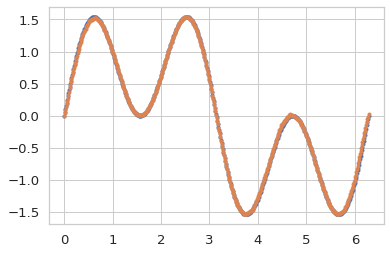

In [65]:
plt.plot(X,Y,'.')
model.eval()
with torch.no_grad():
    plt.plot(X ,model.forward(X.reshape((-1,1))),'.')

# MNIST

In [66]:
import torchvision

!pip3 install torchsampler
!pip3 install torchinfo

from torchinfo import summary
from torch.utils.data import random_split
from torch import nn
from sklearn.metrics import f1_score
from collections import defaultdict
from IPython.display import clear_output
import time
import glob
import requests
from tqdm.notebook import tqdm
from torch.utils.data import SubsetRandomSampler

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загрузим датасет с разделением на трейн и тест

In [67]:
train_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [68]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [69]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [70]:
train_data[0][0].shape

torch.Size([1, 28, 28])

Итак, мы работаем с чб картинками 28х28 пикселей, которые преобразованы в тензоры 1х28х28. Построим MLP для решения задачи классификации тензоров на условные цифры - 10 классов (то есть вход 28х28х1 = 784, выход 10). В качестве метрики качества рассмотрим f1-меру на тесте. 

В трейне выделим часть данных (20%) на валидацию. Заметим, что в датасете есть дисбаланс классов и стоит использовать семплеры, которые учитывают классы.

In [74]:
dataset_size = len(train_data)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [76]:
batch_size = 100

train_batch_gen = torch.utils.data.DataLoader(dataset=train_data, shuffle=False, batch_size=batch_size, sampler=train_sampler)
val_batch_gen = torch.utils.data.DataLoader(dataset=train_data, shuffle=False, batch_size=batch_size, sampler=val_sampler)
test_batch_gen = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=10000)

In [77]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [78]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.fc0 = nn.Linear(784, 256)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.sm = nn.Softmax(dim=1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()


    def forward(self, x):
        layer1 = self.relu1(self.fc0(self.flatten(x)))
        layer2 = self.relu2(self.fc1(self.dropout1(layer1)))
        layer3 = self.fc2(self.dropout2(layer2))
        out = self.sm(layer3)

        return out

Пропишем функции для обучения модели и отрисовки процесса

In [79]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        f1 и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('f1 score', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('score', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [80]:
def train(
    model, 
    criterion,
    optimizer, 
    scheduler, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) f1_score и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += f1_score(y_batch.cpu().numpy(), y_pred, average="macro")

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += f1_score(y_batch.cpu().numpy(), y_pred, average="macro")
            
 

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        # optimization scheduler
        scheduler.step(val_loss)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training f1_score: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation f1_score: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Используем кросс-энтропию в качестве лосса, оптимизатор Adam и контроль темпа обучения

In [81]:
model = MLP().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

In [82]:
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 256]                  200,960
├─ReLU: 1-3                              [1, 256]                  --
├─Dropout: 1-4                           [1, 256]                  --
├─Linear: 1-5                            [1, 256]                  65,792
├─ReLU: 1-6                              [1, 256]                  --
├─Dropout: 1-7                           [1, 256]                  --
├─Linear: 1-8                            [1, 10]                   2,570
├─Softmax: 1-9                           [1, 10]                   --
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.08
Estimated Total Size (MB): 1.08

Модель не перегружена параметрами, можно обучать

Epoch 100 of 100 took 16.171s
  training loss (in-iteration): 	1.486611
  validation loss (in-iteration): 	1.486241
  training f1_score: 			97.60 %
  validation f1_score: 			97.35 %


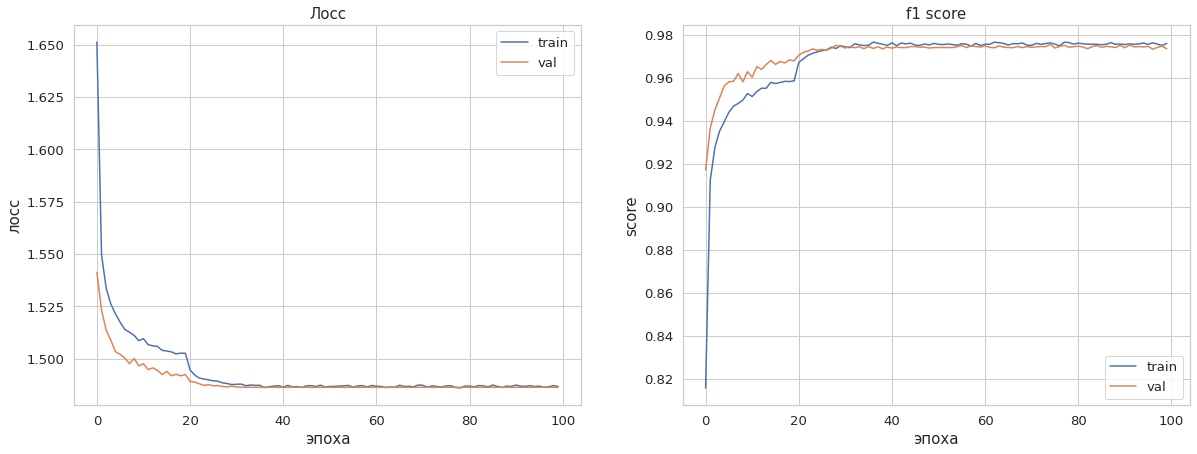

In [83]:
model, history = train(
    model, criterion, optimizer, scheduler, 
    train_batch_gen, val_batch_gen, 
    num_epochs=epochs
)

Модель сошлась еще примерно на 50-ой эпохе. Графики лосса и f1-меры позволяют говорить о том, что модель не переобучилась

In [84]:
model.train(False) 
for X_batch, y_batch in test_batch_gen:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(X_batch)
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    test_f1_score = f1_score(y_batch.cpu().numpy(), y_pred, average="macro")

print("Итоговый результат:")
print("Test F1 score:\t\t{:.2f} %".format(test_f1_score * 100))

Итоговый результат:
Test F1 score:		97.90 %


Вывод: достигнута хорошая метрика на тестовой выборке, обучение прошло успешно